In [3]:
# testing for exact TN charge gap parameter
import sys
sys.path.append("..")

from dmet.model import hubbard
from pyscf import fci
from pyscf.scf import hf
import numpy as np
from cpskit.fci import ci_slater
import scipy.linalg as la
from eomdp.fcicis import get_fciao_cis_wfns
from pyscf import ao2mo


def zero_out_ci(ci, mol, Fstrsa, Fstrsb, imp_idx, occa, occb):
    ''' 
    ci of a large fragment F
    Fstrsa, Fstrsb are cistrings of F
    imp_idx is the index of the small imp orb in F's EOs
    return a ci vector with non-zeros for configs that has imp orb (occa, occb)
    '''
    assert ci.shape[0] == len(Fstrsa)
    assert ci.shape[1] == len(Fstrsb)
    norb = mol.nao
    nci = ci.copy()
    def int2str(i):
        res = bin(i)[2:][::-1]
        return res + "0" * (norb-len(res))
    for addra in range(len(Fstrsa)):
        Fstra = int2str(Fstrsa[addra])
        if Fstra[imp_idx] != occa:
            nci[addra,:] = 0
            continue
        for addrb in range(len(Fstrsb)):
            Fstrb = int2str(Fstrsb[addrb])
            if Fstrb[imp_idx] != occb:
                nci[addra, addrb] = 0
    return nci

def get_matching_fci(ci, imp_idx, mol, normalize=True, debug=False):
    '''
    get fci vectors form the exact fci vector that match the f configs
    '''
    Fstrs = fci.cistring.make_strings(range(mol.nao), mol.nelectron//2)
    c = list()
    for occa in ['1', '0']:
        for occb in ['1', '0']:
            # extract the states where F config consistent with this f config
            cP_ = zero_out_ci(ci, mol, Fstrs, Fstrs, imp_idx, occa, occb)
            if normalize:
                c.append(cP_ / la.norm(cP_))
            else:
                c.append(cP_)
    return c

def get_cgintens(civec, norb, nelec):   
    r'''
    .. math::
        \xi = \sum\limits_{I^\alpha I^\beta} N(I^\alpha I^\beta) |\psi_{I^\alpha I^\beta}| ^ 2
    '''

    def get_cgnum(a, b, norb):

        c = a & b
        alst = [c&(2**x) for x in range(norb)]
        k = 0
        for i in alst:
            if i != 0: k += 1
        del alst
        return k

    strings = fci.cistring.make_strings(range(norb), nelec)

    intens = 0

    for a, stra in enumerate(strings):
        for b, strb in enumerate(strings):
            cgnum = get_cgnum(stra, strb, norb)
            psi = civec[a,b]
            intens += cgnum * psi * psi.conj()
    
    return intens

def get_cgintens_from_2rdm(civec, norb, nelec):

    dm = fci.rdm.make_rdm12_spin1('FCItdm12kern_ab', civec, civec,
                                    norb, (nelec, nelec), None, 0)
    return np.einsum("iiii->", dm)

def hs_1imp(wfnlst, nocc, nvir, h1e, eri):  # for fci wave-function list

    nstate = len(wfnlst)
    
    h = np.zeros((nstate, nstate))
    s = np.zeros((nstate, nstate))

    for i in range(nstate):

        cibra = wfnlst[i]
        for j in range(nstate):

            ciket = wfnlst[j]

            s[i,j] += np.einsum("ij,ij->", cibra.conj(), ciket)
            dm1, dm2 = fci.direct_spin1.trans_rdm12(cibra, ciket, nocc+nvir, (nocc,nocc))
            h[i,j] += np.einsum("ij,ij->", h1e, dm1) + .5 * np.einsum("ijkl,ijkl->", eri, dm2)

    return h, s

def FCI_Atomic(mf): 
    # imitating pyscf.fci.__init__.FCI(), reset h1e, eri and ci0 to SITE basis.

    mol = mf.mol
    mo_c = mf.mo_coeff
    h1e = mf.get_hcore()
    norb = mo_c.shape[1]
    eri = mf._eri
    nelec = getattr(mf, 'nelec', mol.nelec)
    mo_c_occ = mf.mo_coeff[:,np.where(mf.mo_occ==2)[0]]
    ci0 = ci_slater(norb, nelec, (mo_c_occ, mo_c_occ))

    fcisolver = fci.direct_spin1.FCISolver(mol)
    fcisolver_class = fcisolver.__class__
    class CISolver(fcisolver.__class__):
        def __init__(self, mol=None):
            fcisolver_class.__init__(self, mol)
            self.orbsym = None

        def kernel(self, h1e=h1e, eri=eri, norb=norb, nelec=nelec, ci0=ci0,
                   ecore=0., **kwargs):
            return fcisolver_class.kernel(self, h1e, eri, norb, nelec, ci0,
                                          ecore=ecore, **kwargs)
    
    cisolver = CISolver(mol)
    cisolver.__dict__.update(fcisolver.__dict__)
    cisolver.orbsym = None
    return cisolver

mixint_lst = [[], [], [], [], []]
mixext_lst = [[], [], [], []]

def calc(U, ny):

    mol = hubbard.HubbardMole(1, ny, 1, U)
    mol.nelectron = ny
    nocc = nvir = nelec = ny // 2
    norb = ny
    mf = hubbard.RHF_SpinHubbard(mol)
    mf.pbc = True
    mf.kernel()

    fcisolver = FCI_Atomic(mf)    # change ci into LO basis
    fullE, fullci = fcisolver.kernel(nroots=10)
    print("FCI = ", fullE)
    spinoplst = [round(fci.spin_op.spin_square(cis, norb, (nelec, nelec))[0]) for cis in fullci]
    print("S^2 of FCI vectors: ", spinoplst)
    ci = fullci[0]

    # save the intensity of GS
    mixint = get_cgintens(ci, norb, nelec)
    print("Charge gap of GS: ", mixint)
    mixint_lst[4].append(mixint)

    # save the intensity of FCI first excited states
    mixext_lst[3].append(fullE[1] - fullE[0])
    mixint = get_cgintens(fullci[1], norb, nelec)
    print("Charge gap parameter of first triplet FCI: ", mixint)
    mixint_lst[3].append(mixint)


    eri = ao2mo.restore(1, mf._eri, ny)
    h1e = mf.get_hcore()

    dimHf = 4   # dimension of Hilbert space
    simps = [0] * ny

    wfnlst_TN = []
    
    for i in range(len(simps)):
        cs = get_matching_fci(ci, i, mol)
        for j in range(dimHf):
            wfnlst_TN.append(cs[j])

    wfnlst_EOM = get_fciao_cis_wfns(ci, nocc, nvir, mf.mo_coeff)

    wfnlst = wfnlst_TN + wfnlst_EOM # merge the EOM and TN basis sets
    exact_H, exact_S = hs_1imp(wfnlst, nocc, nvir, h1e, eri)

    ranglst = [range(len(wfnlst_TN)), range(len(wfnlst_TN), len(wfnlst)), range(len(wfnlst))]

    for i, rang in enumerate(ranglst):
        print("Calc ansatz {} ...".format(i+1))

        exact_Sp = exact_S[np.ix_(rang, rang)]
        exact_Hp = exact_H[np.ix_(rang, rang)]

        wS_exact, vS_exact = la.eigh(exact_Sp)
        mask = wS_exact > 1e-5
        S_proj = vS_exact.T[mask] @ (exact_Sp+exact_Sp.T)/2 @ vS_exact[:,mask]
        H_proj = vS_exact.T[mask] @ (exact_Hp+exact_Hp.T)/2 @ vS_exact[:,mask]
        wHp_exact, vHp_exact = hf.eig(H_proj, S_proj)   # solve in truncated area

        print("Energy for Ansatz {} = ".format(i+1), wHp_exact[:10])
        mixext_lst[i].append(wHp_exact[1] - wHp_exact[0])

        coeff_in_basis = vS_exact[:,mask] @ vHp_exact

        wfnbasis = np.array(wfnlst)[rang,:,:]

        res_wfn = np.einsum("iab,ij->jab", wfnbasis, coeff_in_basis)
        spinoplst = [round(fci.spin_op.spin_square(res_wfn[i], norb, (nelec, nelec))[0]) for i in range(10)]
        print("S^2 for Ansatz {}: ".format(i+1), spinoplst)
        cgparam = get_cgintens(res_wfn[1], norb, nelec)
        assert cgparam == get_cgintens_from_2rdm(res_wfn[1], norb, nelec)
        print("Charge gap parameter of first triplet of Ansatz {} = ".format(i+1), cgparam)

        mixint_lst[i].append(cgparam)


ny = 6

ulst = np.linspace(1, 50, 50)
for U in ulst: calc(U, ny)



Initialize <dmet.model.hubbard.HubbardMole object at 0x7fc6c031a610> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7fc660f2fbb0>


converged SCF energy = -6.5
FCI =  [-6.60115829 -4.94491687 -4.76688967 -4.76688967 -4.69363464 -3.94241203
 -3.94241203 -3.72015979 -3.72015979 -3.21489276]
S^2 of FCI vectors:  [0, 2, 2, 2, 0, 2, 2, 0, 0, 6]
Charge gap of GS:  1.2967849032388246
Charge gap parameter of first triplet FCI:  0.9472292926033549
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-6.60115829 -4.75446911 -4.75446911 -4.4469502  -4.40622344 -4.40622344
 -3.91758124 -3.91758123 -3.38426868 -3.24169535]
S^2 for Ansatz 1:  [0, 2, 2, 2, 0, 0, 2, 2, 0, 0]
Charge gap parameter of first triplet of Ansatz 1 =  1.1795204618639827
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-6.60115829 -4.93114251 -4.70454978 -4.70454977 -4.53095382 -4.53025027
 -4.37121992 -4.37121991 -4.25848581 -3.88603277]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 0, 0, 0, 0, 2]


AssertionError: 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./10/hubbard_6.csv')

df.keys()

Index(['U', 'ext-TN', 'ext-EOM', 'ext-MIX', 'ext-FCI', 'int-TN', 'int-EOM',
       'int-MIX', 'int-FCI', 'int-GS', 'ext-CISD', 'int-CISD'],
      dtype='object')

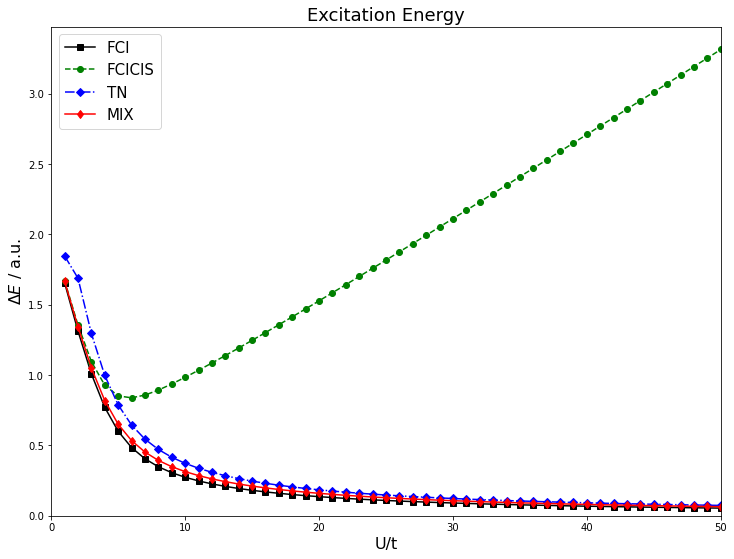

In [3]:
plt.figure(figsize=(12, 9))


plt.plot(df['U'], df['ext-FCI'], label='FCI', color='black', marker='s')
plt.plot(df['U'], df['ext-EOM'], label='FCICIS', color='green', linestyle='--', marker='o')
plt.plot(df['U'], df['ext-TN'], label='TN', color='blue', linestyle='-.', marker='D')
plt.plot(df['U'], df['ext-MIX'], linestyle='solid', marker='d', label='MIX', color='red')
plt.legend(fontsize=15)
plt.xlabel(r"U/t", fontsize=16)
plt.ylabel(r'$\Delta E$ / a.u.', fontsize=16)
plt.xlim(0,50)
plt.ylim(0)
plt.title("Excitation Energy", fontsize=18)
plt.show()

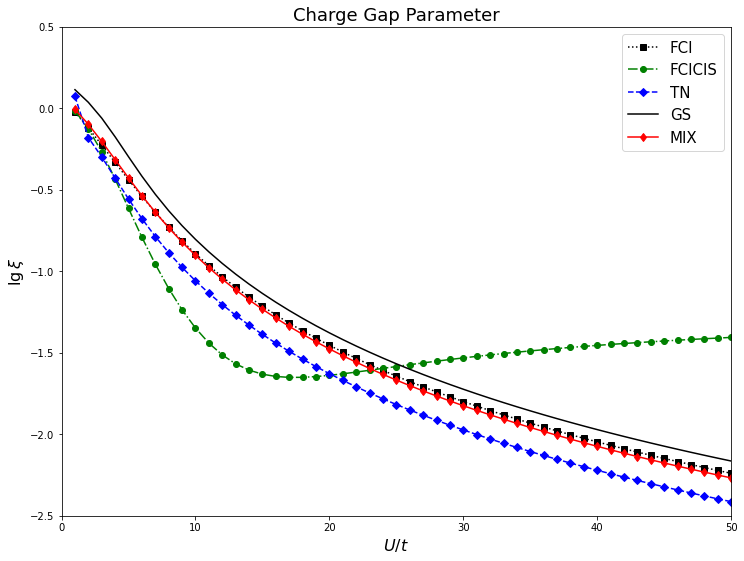

In [4]:
import numpy as np

plt.figure(figsize=(12,9))
plt.plot(df['U'], np.log10(df['int-FCI']), label='FCI', linestyle=':', color='black', marker='s')
plt.plot(df['U'], np.log10(df['int-EOM']), label='FCICIS', linestyle='-.', color='green', marker='o')
plt.plot(df['U'], np.log10(df['int-TN']), label='TN', linestyle='--', color='blue', marker='D')
plt.plot(df['U'], np.log10(df['int-GS']), label='GS', linestyle='solid', color='black')
plt.plot(df['U'], np.log10(df['int-MIX']), linestyle='solid', marker='d', label='MIX', color='red')
plt.xlabel(r"$U/t$", fontsize=16)
plt.ylabel(r"$\lg \xi$", fontsize=16)
plt.legend(fontsize=15)
plt.title("Charge Gap Parameter", fontsize=18)
plt.ylim(-2.5,0.5)
plt.xlim(0,50)
plt.show()

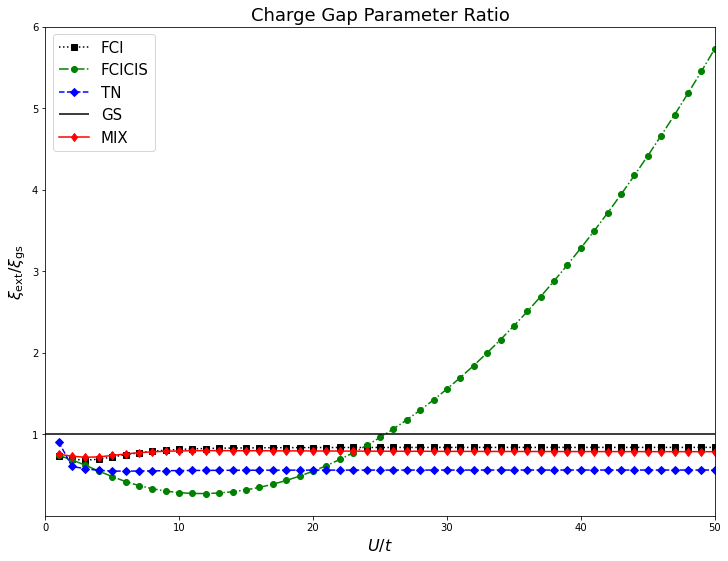

In [5]:
import numpy as np

plt.figure(figsize=(12,9))
plt.plot(df['U'], df['int-FCI']/df['int-GS'], label='FCI', linestyle=':', color='black', marker='s')
plt.plot(df['U'], df['int-EOM']/df['int-GS'], label='FCICIS', linestyle='-.', color='green', marker='o')
plt.plot(df['U'], df['int-TN']/df['int-GS'], label='TN', linestyle='--', color='blue', marker='D')
plt.hlines(1,0,50,color='black', label='GS')
plt.plot(df['U'], df['int-MIX']/df['int-GS'], linestyle='solid', marker='d', label='MIX', color='red')
plt.xlabel(r"$U/t$", fontsize=16)
plt.ylabel(r"$\xi_{\mathrm{ext}} / \xi_{\mathrm{gs}}$", fontsize=16)
plt.legend(fontsize=15)
plt.title("Charge Gap Parameter Ratio", fontsize=18)
plt.xlim(0,50)
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame()
df['U'] = ulst
df['ext-TN'], df['ext-EOM'], df['ext-MIX'], df['ext-FCI'] = mixext_lst
df['int-TN'], df['int-EOM'], df['int-MIX'], df['int-FCI'], df['int-GS'] = mixint_lst

df.to_csv("./10/hubbard_6.csv", index=False)
